In [0]:
import tensorflow as tf

In [0]:
# More imports

# layers
from tensorflow.keras.layers import Input, Dense, Flatten
# import pretrained model for transfer learning
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
# model 
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import SGD, Adam
# preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# glob
from glob import glob

# additional imports
import numpy as np # linear algebra
import pandas as pd # data manipulation 
import matplotlib.pyplot as plt # data visualisation
import sys, os # wut ?!

In [0]:
# Data source : https://mmspg.epfl.ch/downloads/food-image-datasets/
# download the dataset through FTP
# its a binary classification dataset that contains food images and the images that aren't food
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-04-14 20:51:09--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  42.6MB/s    in 9.5s    

2020-04-14 20:51:19 (44.9 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [0]:
!unzip -qq -o Food-5K.zip

In [0]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [0]:
!ls Food-5K

evaluation  training  validation


In [0]:
!ls Food-5K/training

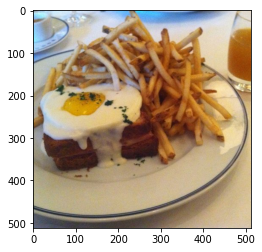

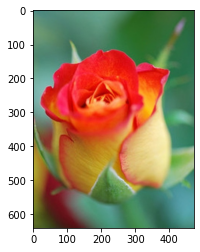

In [0]:
# so the data format is {label}_{image_id}.jpg
# 0 is for the ones that doesn't contain any food
# and 1 is for the food photos
# let's take a look to random sample
PATH = 'Food-5K/'
plt.imshow(image.load_img(PATH + "training/1_404.jpg"))
plt.show()
plt.imshow(image.load_img(PATH + "training/0_808.jpg"))
plt.show()

In [0]:
!mkdir data

In [0]:
# Make directories to store the data as Keras-style which as the following:
# data
#  - train
#     - class1
#     - class2
#     .
#     .
#     .
#  - validation
#     - class1
#     - class2
#     .
#     .
#     .
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [0]:
# Move the images
# Note: we will consider 'training to be the train set
#       'validation' folder will be the test set
#       ignore 'evaluation' set
# well we can combine the evaluation set with any other folders
# but the file names would conflict so it may be harder to prepare it
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [0]:
train_path = 'data/train'
valid_path = 'data/test'

In [0]:
# These images are pretty big and of different sizes
# let's load them all in as the same (smaller) size
IMAGE_SIZE = [224, 224]

In [0]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [0]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

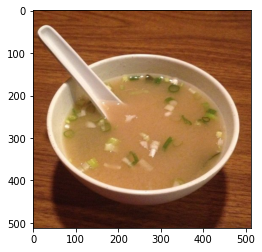

In [0]:
# lets pick an image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [0]:
# input_shape = IMAGE_SIZE + [3] since we have 3 more value for RGB channels
# weights = 'imagenet' so the model downloads pretrained weights from 
# vgg trained on a imagenet dataset
# include_top = False because instead of getting full VGG network
# we just get everything from bottom to the final convolution
# and excluding the last (head) layer. 
# There is no flatten and none of the final dense layers
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top = False)

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
# freeze pretrained model weights so when we call ptm.fit()
# weights won't be changed by gradient descent 
ptm.trainable = False 

In [0]:
# map the data into feature vectors 

# Keras image data generator returns classes one-hot encoded

# lets create the "head" of the neural network
K = len(folders) # remember that the "folders" is the total number of the classes
x = Flatten()(ptm.output)
# softmax should be the natural choice when your targets are one-hot encoded
# so instead of having an N length vector full of ones and zeros
# we'll instead have an (N,K) target matrix 
# using softmax will be good
# if you want to copy this code to work on a different dataset with more classes
x = Dense(K, activation = 'softmax')(x)

In [0]:
# create a model object
# input will be the input of pretrained model
model = Model(inputs=ptm.input, outputs = x)

In [0]:
# view the structure of the model
model.summary()

In [0]:
# create an instance of ImageDataGenerator
# every parameter of the ImageDataGenerator is for data augmentation
# also notice that we passed the preprocessing function that we got from 
# importing phase of vgg module
# these models are pretrained, so we need to pass the data like the data that 
# the model trained. preprocess_input comes handy in that situation
# we can use preprocess_input function to preprocess the our data as the
# model uses 
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

In [0]:
batch_size = 128 # every batch has the 128 images
# create generators
# first argument is the where data lives in
# shuffle is True on train_gen the data is shuffled on each epoch
train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# since the generator returns the data one-hot encoded, 
# we use categorical loss rather than the sparse categorical loss
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [0]:
# fit the model with generators
# steps_per_epoch: this is the number of train steps per epoch
# which is defined as the ceiling of the number of samples by divided by the batch_size
# validation_steps: this is the number of validation steps per epoch 
# also defined as the ceiling of the number of validation data by divided by the batch_size
r = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    steps_per_epoch = int(np.ceil(len(image_files) / batch_size)),
    validation_steps = int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/10
24/24 [==============================] - 61s 3s/step - loss: 1.4189 - accuracy: 0.9360 - val_loss: 1.0407 - val_accuracy: 0.9670
Epoch 2/10
24/24 [==============================] - 61s 3s/step - loss: 0.3982 - accuracy: 0.9793 - val_loss: 0.6446 - val_accuracy: 0.9730
Epoch 3/10
24/24 [==============================] - 61s 3s/step - loss: 0.3473 - accuracy: 0.9847 - val_loss: 1.1332 - val_accuracy: 0.9650
Epoch 4/10
24/24 [==============================] - 61s 3s/step - loss: 0.2950 - accuracy: 0.9863 - val_loss: 0.8409 - val_accuracy: 0.9760
Epoch 5/10
24/24 [==============================] - 61s 3s/step - loss: 0.2376 - accuracy: 0.9900 - val_loss: 0.9314 - val_accuracy: 0.9690
Epoch 6/10
24/24 [==============================] - 62s 3s/step - loss: 0.1583 - accuracy: 0.9913 - val_loss: 0.9032 - val_accuracy: 0.9730
Epoch 7/10
24/24 [==============================] - 62s 3s/step - loss: 0.2359 - accuracy: 0.9890 - val_loss: 0.9358 - val_accuracy: 0.9690
Epoch 8/10
24/24 [==

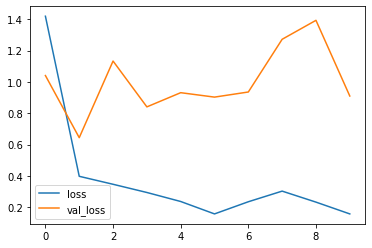

In [0]:
# loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

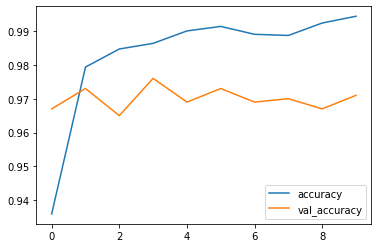

In [0]:
# accuracies
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()